## CLIM 680 Project: Nino Index Analysis (NOAA GFDL)
### Douglas Nedza

Calculate and plot the composite maps for a chosen index.

The data I am using for this analysis is from a CMIP5 pre-industrial run.  Due to the independence of this dataset with observations, a climate index will be calculated from the chosen dataset.

## Import necessary Python packages and Load the Data

In [1]:
import numpy as np;
import xarray as xr;
import matplotlib.pyplot as plt;

import cartopy.crs as ccrs;
import cartopy.mpl.ticker as cticker;
from cartopy.util import add_cyclic_point;

from scipy.stats import ttest_ind;

from scipy.stats import pearsonr

from scipy.stats import linregress as lr;

import warnings

from dask.diagnostics import ProgressBar


In [2]:
warnings.filterwarnings( action = 'ignore' );

In [3]:
## Read dataset into notebook.  
##Calculate the annual means simultaneously to remove the dominant effect of the seasonal cycle. This also decreases the amount of data in memory.  
sst_path = '/shared/cmip5/data/piControl/ocean/mon/Omon/tos/NOAA-GFDL.GFDL-CM3/r1i1p1/';
atmos_path = '/shared/cmip5/data/piControl/atmos/mon/Amon/';
ts_path = atmos_path + '/ts/NOAA-GFDL.GFDL-CM3/r1i1p1/';
pr_path = atmos_path + '/pr/NOAA-GFDL.GFDL-CM3/r1i1p1/';
sst_file = 'tos_Omon_GFDL-CM3_piControl_r1i1p1_*.nc';
ts_file = 'ts_Amon_GFDL-CM3_piControl_r1i1p1_*.nc';
pr_file =  'pr_Amon_GFDL-CM3_piControl_r1i1p1_*.nc';
sst_ds = xr.open_mfdataset( ( sst_path + sst_file ), concat_dim = 'time' ).groupby( 'time.year' ).mean( dim = 'time' );
ts_ds = xr.open_mfdataset( ( ts_path + ts_file ), concat_dim = 'time' ).groupby( 'time.year' ).mean( dim = 'time' );
pr_ds = xr.open_mfdataset( ( pr_path + pr_file ), concat_dim = 'time' ).groupby( 'time.year' ).mean( dim = 'time' );
##Convert precipitation from mm/s to mm/day
pr_ds['pr'] = pr_ds['pr'] * 8.64 * ( 10 ** 4 );
sst_ds
## Note that there is no units attribute for this file.

<xarray.Dataset>
Dimensions:       (bnds: 2, rlat: 200, rlon: 360, vertices: 4, year: 500)
Coordinates:
  * bnds          (bnds) float64 1.0 2.0
  * rlon          (rlon) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * rlat          (rlat) float64 -81.5 -80.5 -79.5 -78.5 ... 86.5 87.5 88.5 89.5
    lat           (rlat, rlon) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
    lon           (rlat, rlon) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
  * vertices      (vertices) int32 0 1 2 3
  * year          (year) int64 1 2 3 4 5 6 7 8 ... 494 495 496 497 498 499 500
Data variables:
    average_DT    (year) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    tos           (year, rlat, rlon) float32 dask.array<chunksize=(1, 200, 360), meta=np.ndarray>
    lat_vertices  (year, rlat, rlon, vertices) float64 dask.array<chunksize=(1, 200, 360, 4), meta=np.ndarray>
    lon_vertices  (year, rlat, rlon, vertices) float64 dask.array<chunksize=(1, 200, 360, 4), meta=np.ndarray>

In [4]:
##Shift the longitude of the ocean dataset to be consistent with the atmospheric datasets
new_rlon = ( sst_ds['rlon'] + 360 ) % 360;
sst_ds = sst_ds.assign_coords( rlon = new_rlon );
sst_ds = sst_ds.sortby( sst_ds['rlon'] );
sst_ds

<xarray.Dataset>
Dimensions:       (bnds: 2, rlat: 200, rlon: 360, vertices: 4, year: 500)
Coordinates:
  * bnds          (bnds) float64 1.0 2.0
  * rlon          (rlon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * rlat          (rlat) float64 -81.5 -80.5 -79.5 -78.5 ... 86.5 87.5 88.5 89.5
    lat           (rlat, rlon) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
    lon           (rlat, rlon) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
  * vertices      (vertices) int32 0 1 2 3
  * year          (year) int64 1 2 3 4 5 6 7 8 ... 494 495 496 497 498 499 500
Data variables:
    average_DT    (year) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    tos           (year, rlat, rlon) float32 dask.array<chunksize=(1, 200, 360), meta=np.ndarray>
    lat_vertices  (year, rlat, rlon, vertices) float64 dask.array<chunksize=(1, 200, 360, 4), meta=np.ndarray>
    lon_vertices  (year, rlat, rlon, vertices) float64 dask.array<chunksize=(1, 200, 360, 4), meta=np.ndarray>

## Calculate the NINO34 Index, from 150W-120W and 5S-5N

In [5]:
sst_nino = sst_ds.sel( rlat = slice( -5, 5 ),
                         rlon = slice( 360-150, 360-120 ) );
sst_nino

<xarray.Dataset>
Dimensions:       (bnds: 2, rlat: 24, rlon: 30, vertices: 4, year: 500)
Coordinates:
  * bnds          (bnds) float64 1.0 2.0
  * rlon          (rlon) float64 210.5 211.5 212.5 213.5 ... 237.5 238.5 239.5
  * rlat          (rlat) float64 -4.717 -4.191 -3.691 ... 3.691 4.191 4.717
    lat           (rlat, rlon) float32 dask.array<chunksize=(24, 30), meta=np.ndarray>
    lon           (rlat, rlon) float32 dask.array<chunksize=(24, 30), meta=np.ndarray>
  * vertices      (vertices) int32 0 1 2 3
  * year          (year) int64 1 2 3 4 5 6 7 8 ... 494 495 496 497 498 499 500
Data variables:
    average_DT    (year) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    tos           (year, rlat, rlon) float32 dask.array<chunksize=(1, 24, 30), meta=np.ndarray>
    lat_vertices  (year, rlat, rlon, vertices) float64 dask.array<chunksize=(1, 24, 30, 4), meta=np.ndarray>
    lon_vertices  (year, rlat, rlon, vertices) float64 dask.array<chunksize=(1, 24, 30, 4), meta=np.ndarray>

##Make the figure larger
fig = plt.figure( figsize = ( 11, 8.5 ) );

#Set the axes using the specified map projection
ax = plt.axes( projection = ccrs.PlateCarree() );

#Make a filled contour plot
cs = ax.contourf( sst_nino['lon'],
                 sst_nino['lat'],
                 sst_nino['tos'][0,:,:,],
                 transform = ccrs.PlateCarree(),
                 cmap = 'coolwarm', extend = 'both' );

#Add coastlines
ax.coastlines();

#Add gridlines
ax.gridlines();

##Define the xticks for longitude
ax.set_xticks( np.arange( -180, 181, 60 ), crs = ccrs.PlateCarree() );
lon_formatter = cticker.LongitudeFormatter();
ax.xaxis.set_major_formatter( lon_formatter );

##Define the yticks for latitude
ax.set_yticks( np.arange( -90, 91, 30 ), crs = ccrs.PlateCarree() );
lat_formatter = cticker.LatitudeFormatter();
ax.yaxis.set_major_formatter( lat_formatter );

#Add colorbar
cbar = plt.colorbar( cs, shrink = 0.7,
                    orientation = 'horizontal',
                    label = 'SST degK' );

#Add title.  Note that using .groupby().mean() removes the attributes that describe the dataset
plt.title( 'Nino3.4 Index Region, displaying first time step' );

<xarray.DataArray 'tos' (year: 500)>
dask.array<mean_agg-aggregate, shape=(500,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1 2 3 4 5 6 7 8 9 ... 493 494 495 496 497 498 499 500


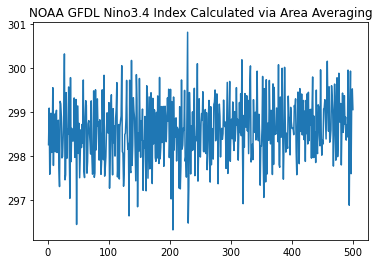

In [6]:
nino_ind = sst_nino['tos'].mean( dim = ( 'rlat', 'rlon' ) );
print( nino_ind );
plt.plot( nino_ind['year'], nino_ind );
plt.title( 'NOAA GFDL Nino3.4 Index Calculated via Area Averaging' );

### Center the Time Series

Text(0, 0.5, 'Nino3.4 Anomaly degC')

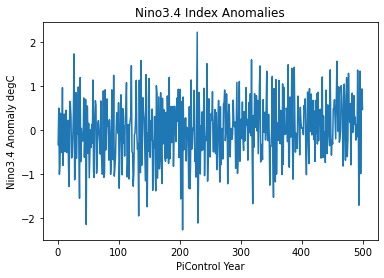

In [7]:
nino_mean = nino_ind.mean();
nino_ind = nino_ind - nino_mean;
plt.plot( nino_ind['year'], nino_ind );
plt.title( 'Nino3.4 Index Anomalies' );
plt.xlabel( 'PiControl Year' );
plt.ylabel( 'Nino3.4 Anomaly degC' )

## Determine the Composite maps of Precipitation and Surface Temperature relative to the calculated AMO index

Based on a visual inspection of the variability of the Area Averaged NASST Index, thresholds are chosen at +- 0.2 degrees celsius

In [8]:
##By omitting return values for the where() function, Nans will be returned where the condition is not met
pos_nino = nino_ind.where( nino_ind >= 0.5 );
neg_nino = nino_ind.where( nino_ind <= -0.5 );
neutral = nino_ind.where( np.logical_and( nino_ind > -0.5, nino_ind < 0.5 ) );
##The 'and' command will attempt to find a single true/false value

In [9]:
print( 'Positive Nino3.4: ', pos_nino.count( dim = 'year' ).values );
print( 'Negative Nino3.4: ', neg_nino.count( dim = 'year' ).values );
print( 'Neutral: ', neutral.count( dim = 'year' ).values );

counts = [pos_nino.count( dim = 'year' ).values, 
         neg_nino.count( dim = 'year' ).values, 
         neutral.count( dim = 'year' ).values ];
print( counts );

Positive Nino3.4:  123
Negative Nino3.4:  129
Neutral:  248
[array(123), array(129), array(248)]


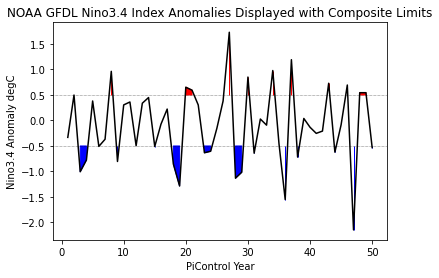

In [10]:
plt.plot( nino_ind['year'][0:50], nino_ind[0:50], 'k' );
plt.fill_between( nino_ind['year'][0:50], 0.5, pos_nino[0:50], color = 'red' );
plt.fill_between( nino_ind['year'][0:50], neg_nino[0:50], -0.5, color = 'blue' );
plt.axhline( 0.5, color = 'black', linewidth = 0.5, linestyle = 'dotted' );
plt.axhline( -0.5, color = 'black', linewidth = 0.5, linestyle = 'dotted' );
plt.title( 'NOAA GFDL Nino3.4 Index Anomalies Displayed with Composite Limits' );
plt.ylabel( 'Nino3.4 Anomaly degC' );
plt.xlabel( 'PiControl Year' );

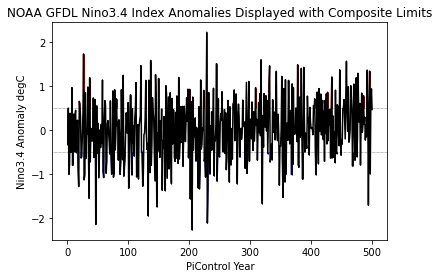

In [11]:
plt.plot( nino_ind['year'], nino_ind, 'k' );
plt.fill_between( nino_ind['year'], 0.5, pos_nino, color = 'red' );
plt.fill_between( nino_ind['year'], neg_nino, -0.5, color = 'blue' );
plt.axhline( 0.5, color = 'black', linewidth = 0.5, linestyle = 'dotted' );
plt.axhline( -0.5, color = 'black', linewidth = 0.5, linestyle = 'dotted' );
plt.title( 'NOAA GFDL Nino3.4 Index Anomalies Displayed with Composite Limits' );
plt.ylabel( 'Nino3.4 Anomaly degC' );
plt.xlabel( 'PiControl Year' );

## Sea Surface Temperature

In [12]:
sst_climo = sst_ds.mean( dim = 'year' );
sst_anoms = sst_ds - sst_climo;
sst_anoms

<xarray.Dataset>
Dimensions:       (bnds: 2, rlat: 200, rlon: 360, vertices: 4, year: 500)
Coordinates:
  * bnds          (bnds) float64 1.0 2.0
  * rlon          (rlon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * rlat          (rlat) float64 -81.5 -80.5 -79.5 -78.5 ... 86.5 87.5 88.5 89.5
    lat           (rlat, rlon) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
    lon           (rlat, rlon) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
  * vertices      (vertices) int32 0 1 2 3
  * year          (year) int64 1 2 3 4 5 6 7 8 ... 494 495 496 497 498 499 500
Data variables:
    average_DT    (year) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    tos           (year, rlat, rlon) float32 dask.array<chunksize=(1, 200, 360), meta=np.ndarray>
    lat_vertices  (year, rlat, rlon, vertices) float64 dask.array<chunksize=(1, 200, 360, 4), meta=np.ndarray>
    lon_vertices  (year, rlat, rlon, vertices) float64 dask.array<chunksize=(1, 200, 360, 4), meta=np.ndarray>

In [13]:
pos_sst = sst_anoms.sel( year = pos_nino.dropna( dim = 'year' )['year'] ).mean( dim = 'year' );
neg_sst = sst_anoms.sel( year = neg_nino.dropna( dim = 'year' )['year'] ).mean( dim = 'year' );
neutral_sst = sst_anoms.sel( year = neutral.dropna( dim = 'year' )['year'] ).mean( dim = 'year' );

comp_sst = [pos_sst, neg_sst, neutral_sst];
comp_sst                      

[<xarray.Dataset>
 Dimensions:       (bnds: 2, rlat: 200, rlon: 360, vertices: 4)
 Coordinates:
   * bnds          (bnds) float64 1.0 2.0
   * rlon          (rlon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
   * rlat          (rlat) float64 -81.5 -80.5 -79.5 -78.5 ... 86.5 87.5 88.5 89.5
     lat           (rlat, rlon) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
     lon           (rlat, rlon) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
   * vertices      (vertices) int32 0 1 2 3
 Data variables:
     average_DT    timedelta64[ns] dask.array<chunksize=(), meta=np.ndarray>
     tos           (rlat, rlon) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
     lat_vertices  (rlat, rlon, vertices) float64 dask.array<chunksize=(200, 360, 4), meta=np.ndarray>
     lon_vertices  (rlat, rlon, vertices) float64 dask.array<chunksize=(200, 360, 4), meta=np.ndarray>,
 <xarray.Dataset>
 Dimensions:       (bnds: 2, rlat: 200, rlon: 360, vertices: 4)
 

Text(0.5, 0.98, 'NOAA GFDL Composite SST Anomalies during Nino3.4 Variations')

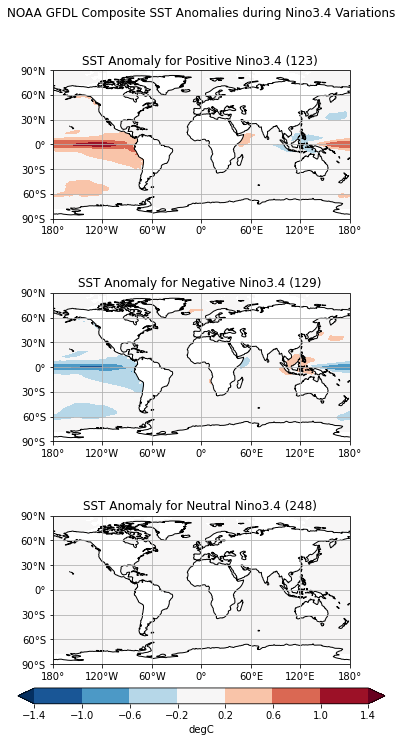

In [14]:
labels = ['Positive Nino3.4', 'Negative Nino3.4', 'Neutral Nino3.4'];
clevs = np.arange( -1.4, 1.8, 0.4 );

## Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots( nrows = 3, ncols = 1,
                       subplot_kw = {'projection': ccrs.PlateCarree() },
                       figsize = (8.5, 11) );
## axs is a 2 dimensional array of 'GeoAxes'.
##We will flatten this into a 1D array
axs = axs.flatten();

##Loop over each of the conditions and plot
for i, nasst in enumerate( comp_sst ):
    ##Select the comp
    data = comp_sst[i]['tos'];
    ##Add the cyclic point
    data,lons = add_cyclic_point( data, coord = comp_sst[i]['rlon'] );
    ##Create the contour plot
    cs = axs[i].contourf( lons, comp_sst[i]['rlat'], data, clevs,
                        transform = ccrs.PlateCarree(),
                        cmap = 'RdBu_r', extend = 'both' );
    ##Longitude labels 
    axs[i].set_xticks( np.arange( -180, 181, 60 ), crs = ccrs.PlateCarree() );
    lon_formatter = cticker.LongitudeFormatter();
    axs[i].xaxis.set_major_formatter( lon_formatter );
    ##Latitude labels
    axs[i].set_yticks( np.arange( -90, 91, 30 ), crs = ccrs.PlateCarree() );
    lat_formatter = cticker.LatitudeFormatter();
    axs[i].yaxis.set_major_formatter( lat_formatter );
    ##Title each subplot with the name of the composite
    axs[i].set_title( 'SST Anomaly for ' + labels[i] + ' (' + str(counts[i]) + ') ' );
    ##Draw the coastlines for each subplot
    axs[i].coastlines();
    axs[i].gridlines();
    
    
##Adjust the location of the subplots to make room for colorbar
fig.subplots_adjust( bottom = 0.15, top = 0.9, left = 0.05, right = 0.95,
                   wspace = 0.1, hspace = 0.5 );
##Add a colorbar axis
cbar_ax = fig.add_axes( [0.2, 0.1, 0.6, 0.02] );
cbar = fig.colorbar( cs, cax = cbar_ax, orientation = 'horizontal', label = 'degC' );

plt.suptitle( 'NOAA GFDL Composite SST Anomalies during Nino3.4 Variations')

SST variations in synchrony with NINO3.4 appear very limited to the region of the Pacific Ocean associated with ENSO.

In [15]:
ptest = 0.05; 

a = sst_anoms.sel( year = pos_nino.dropna( dim = 'year' )['year'] );
b = sst_anoms.sel( year = neutral.dropna( dim = 'year' )['year'] );
c = sst_anoms.sel( year = neg_nino.dropna( dim = 'year' )['year'] );

pos_tstat,pos_pval = ttest_ind( a['tos'], b['tos'], equal_var = False );
neg_tstat,neg_pval = ttest_ind( c['tos'], b['tos'], equal_var = False );


In [16]:
pos_mask_diff = pos_sst['tos'].where( pos_pval < ptest );
neg_mask_diff = neg_sst['tos'].where( neg_pval < ptest );

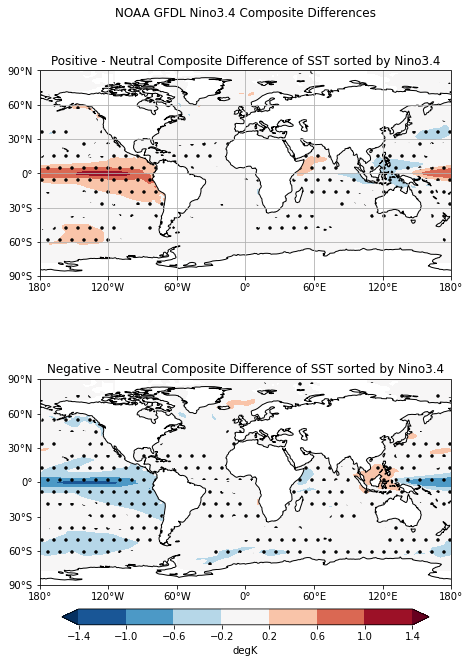

In [17]:
labels = ['Positive - Neutral', 'Negative - Neutral'];
clevs = np.arange( -1.4, 1.8, 0.4 );

fig, axs = plt.subplots( nrows = 2, ncols = 1,
                       subplot_kw = {'projection':ccrs.PlateCarree()},
                       figsize = (8.5,11) );
axs = axs.flatten();

#for i,enso in enumerate( diff_precip ):
data = pos_sst['tos'] - neutral_sst['tos'];

data,lons = add_cyclic_point( data, coord = sst_anoms['rlon'] );
mask_data,lons = add_cyclic_point( pos_mask_diff, coord=sst_anoms['rlon'] );

cs = axs[0].contourf( lons, pos_sst['rlat'], data, clevs,
                        transform = ccrs.PlateCarree(),
                        cmap = 'RdBu_r', extend = 'both' );
axs[0].contourf( lons, sst_anoms['rlat'], mask_data,
            [0,1], transform = ccrs.PlateCarree(), colors = 'None',
            hatches = ['.'], extend = 'both', alpha = 0 );
axs[0].set_title( labels[0] + ' Composite Difference of SST sorted by Nino3.4' );
axs[0].coastlines();
axs[0].gridlines();
##Longitude Labels
axs[0].set_xticks( np.arange( -180, 181, 60 ), crs = ccrs.PlateCarree() );
lon_formatter = cticker.LongitudeFormatter();
axs[0].xaxis.set_major_formatter( lon_formatter );
##Latitude labels
axs[0].set_yticks( np.arange( -90, 91, 30 ), crs = ccrs.PlateCarree() );
lat_formatter = cticker.LatitudeFormatter();
axs[0].yaxis.set_major_formatter( lat_formatter );


data = neg_sst['tos'] - neutral_sst['tos'];

data,lons = add_cyclic_point( data, coord = sst_anoms['rlon'] );
mask_data,lons = add_cyclic_point( neg_mask_diff, coord=sst_anoms['rlon'] );

cs = axs[1].contourf( lons, neg_sst['rlat'], data, clevs,
                        transform = ccrs.PlateCarree(),
                        cmap = 'RdBu_r', extend = 'both' );
axs[1].contourf( lons, sst_anoms['rlat'], mask_data,
            [0,1], transform = ccrs.PlateCarree(), colors = 'None',
            hatches = ['.'], extend = 'both', alpha = 0 );
axs[1].set_title( labels[1] + ' Composite Difference of SST sorted by Nino3.4' );
axs[1].coastlines();
##Longitude Labels
axs[1].set_xticks( np.arange( -180, 181, 60 ), crs = ccrs.PlateCarree() );
lon_formatter = cticker.LongitudeFormatter();
axs[1].xaxis.set_major_formatter( lon_formatter );
##Latitude labels
axs[1].set_yticks( np.arange( -90, 91, 30 ), crs = ccrs.PlateCarree() );
lat_formatter = cticker.LatitudeFormatter();
axs[1].yaxis.set_major_formatter( lat_formatter );

    
fig.subplots_adjust( bottom = 0.25, top = 0.9, left = 0.05, right = 0.95,
                   wspace = 0.1, hspace = 0.5 );
cbar_ax = fig.add_axes( [0.2, 0.2, 0.6, 0.02] );
cbar = fig.colorbar( cs, cax = cbar_ax, orientation = 'horizontal', label = 'degK' );
plt.suptitle( 'NOAA GFDL Nino3.4 Composite Differences' );

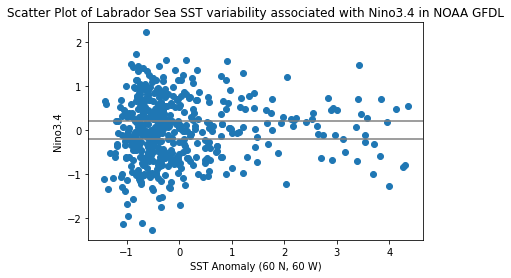

In [18]:
##Select out the point for the high composite value
pt_sst = sst_anoms.sel( rlat = 60, rlon = 360-60, method = 'nearest' );
plt.scatter( pt_sst['tos'], nino_ind );
plt.xlabel( 'SST Anomaly (60 N, 60 W)' );
plt.ylabel( 'Nino3.4' );

plt.axhline( 0.2, color = 'gray' );
plt.axhline( -0.2, color = 'gray' );
plt.title( 'Scatter Plot of Labrador Sea SST variability associated with Nino3.4 in NOAA GFDL' );

## Surface Temperature

In [19]:
##Create a climatology to find the precipitation anomalies
ts_climo = ts_ds.mean( dim = 'year' );
ts_anoms = ts_ds - ts_climo;
ts_anoms

<xarray.Dataset>
Dimensions:     (bnds: 2, lat: 90, lon: 144, year: 500)
Coordinates:
  * lat         (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon         (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * year        (year) int64 1 2 3 4 5 6 7 8 ... 493 494 495 496 497 498 499 500
Dimensions without coordinates: bnds
Data variables:
    lat_bnds    (year, lat, bnds) float64 dask.array<chunksize=(1, 90, 2), meta=np.ndarray>
    lon_bnds    (year, lon, bnds) float64 dask.array<chunksize=(1, 144, 2), meta=np.ndarray>
    ts          (year, lat, lon) float32 dask.array<chunksize=(1, 90, 144), meta=np.ndarray>
    average_DT  (year) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>

In [20]:
pos_ts = ts_anoms.sel( year = pos_nino.dropna( dim = 'year' )['year'] ).mean( dim = 'year' );
neg_ts = ts_anoms.sel( year = neg_nino.dropna( dim = 'year' )['year'] ).mean( dim = 'year' );
neutral_ts = ts_anoms.sel( year = neutral.dropna( dim = 'year' )['year'] ).mean( dim = 'year' );

comp_ts = [pos_ts, neg_ts, neutral_ts];
comp_ts                      

[<xarray.Dataset>
 Dimensions:     (bnds: 2, lat: 90, lon: 144)
 Coordinates:
   * lat         (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
   * lon         (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
 Dimensions without coordinates: bnds
 Data variables:
     lat_bnds    (lat, bnds) float64 dask.array<chunksize=(90, 2), meta=np.ndarray>
     lon_bnds    (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
     ts          (lat, lon) float32 dask.array<chunksize=(90, 144), meta=np.ndarray>
     average_DT  timedelta64[ns] dask.array<chunksize=(), meta=np.ndarray>,
 <xarray.Dataset>
 Dimensions:     (bnds: 2, lat: 90, lon: 144)
 Coordinates:
   * lat         (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
   * lon         (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
 Dimensions without coordinates: bnds
 Data variables:
     lat_bnds    (lat, bnds) float64 dask.array<chunksize=(90, 2), meta=np.ndarray>
    

Text(0.5, 0.98, 'NOAA GFDL Composite Surface Temperature Anomalies during Nino3.4 Variations')

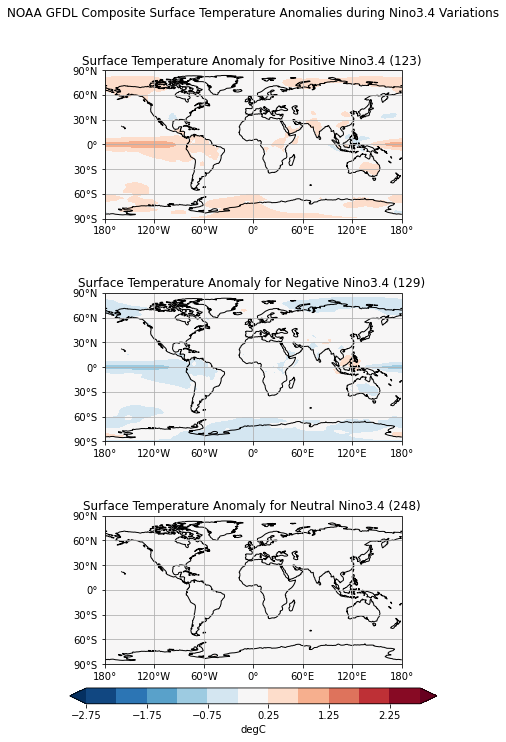

In [21]:
labels = ['Positive Nino3.4', 'Negative Nino3.4', 'Neutral Nino3.4'];
clevs = np.arange( -2.75, 3.25, 0.5 );

## Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots( nrows = 3, ncols = 1,
                       subplot_kw = {'projection': ccrs.PlateCarree() },
                       figsize = (8.5, 11) );
## axs is a 2 dimensional array of 'GeoAxes'.
##We will flatten this into a 1D array
axs = axs.flatten();

##Loop over each of the conditions and plot
for i, nasst in enumerate( comp_ts ):
    ##Select the comp
    data = comp_ts[i]['ts'];
    ##Add the cyclic point
    data,lons = add_cyclic_point( data, coord = comp_ts[i]['lon'] );
    ##Create the contour plot
    cs = axs[i].contourf( lons, comp_ts[i]['lat'], data, clevs,
                        transform = ccrs.PlateCarree(),
                        cmap = 'RdBu_r', extend = 'both' );
    ##Longitude labels 
    axs[i].set_xticks( np.arange( -180, 181, 60 ), crs = ccrs.PlateCarree() );
    lon_formatter = cticker.LongitudeFormatter();
    axs[i].xaxis.set_major_formatter( lon_formatter );
    ##Latitude labels
    axs[i].set_yticks( np.arange( -90, 91, 30 ), crs = ccrs.PlateCarree() );
    lat_formatter = cticker.LatitudeFormatter();
    axs[i].yaxis.set_major_formatter( lat_formatter );
    ##Title each subplot with the name of the composite
    axs[i].set_title( 'Surface Temperature Anomaly for ' + labels[i] + ' (' + str(counts[i]) + ') ' );
    ##Draw the coastlines for each subplot
    axs[i].coastlines();
    axs[i].gridlines();
    
    
##Adjust the location of the subplots to make room for colorbar
fig.subplots_adjust( bottom = 0.15, top = 0.9, left = 0.05, right = 0.95,
                   wspace = 0.1, hspace = 0.5 );
##Add a colorbar axis
cbar_ax = fig.add_axes( [0.2, 0.1, 0.6, 0.02] );
cbar = fig.colorbar( cs, cax = cbar_ax, orientation = 'horizontal', label = 'degC' );

plt.suptitle( 'NOAA GFDL Composite Surface Temperature Anomalies during Nino3.4 Variations')

Surface Temperature Anomalies associated with NINO3.4 variations are more widespread due to atmospheric teleconnections.

In [22]:
diff_ts = [pos_ts - neutral_ts, neg_ts-neutral_ts];
diff_ts

[<xarray.Dataset>
 Dimensions:     (bnds: 2, lat: 90, lon: 144)
 Coordinates:
   * lat         (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
   * lon         (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
 Dimensions without coordinates: bnds
 Data variables:
     lat_bnds    (lat, bnds) float64 dask.array<chunksize=(90, 2), meta=np.ndarray>
     lon_bnds    (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
     ts          (lat, lon) float32 dask.array<chunksize=(90, 144), meta=np.ndarray>
     average_DT  timedelta64[ns] dask.array<chunksize=(), meta=np.ndarray>,
 <xarray.Dataset>
 Dimensions:     (bnds: 2, lat: 90, lon: 144)
 Coordinates:
   * lat         (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
   * lon         (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
 Dimensions without coordinates: bnds
 Data variables:
     lat_bnds    (lat, bnds) float64 dask.array<chunksize=(90, 2), meta=np.ndarray>
    

In [23]:
ptest = 0.05; 

a = ts_anoms.sel( year = pos_nino.dropna( dim = 'year' )['year'] );
b = ts_anoms.sel( year = neutral.dropna( dim = 'year' )['year'] );
c = ts_anoms.sel( year = neg_nino.dropna( dim = 'year' )['year'] );

pos_tstat,pos_pval = ttest_ind( a['ts'], b['ts'], equal_var = False );
neg_tstat,neg_pval = ttest_ind( c['ts'], b['ts'], equal_var = False );


In [24]:
pos_mask_diff = pos_ts['ts'].where( pos_pval < ptest );
neg_mask_diff = neg_ts['ts'].where( neg_pval < ptest );

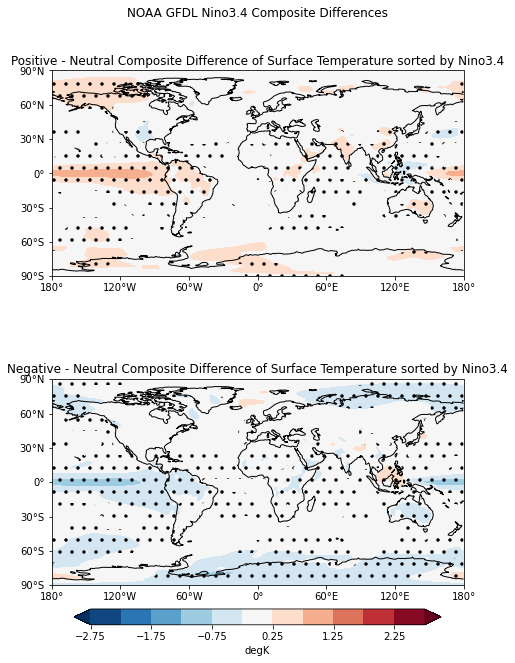

In [25]:
labels = ['Positive - Neutral', 'Negative - Neutral'];
clevs = np.arange( -2.75, 3.25, 0.5 );

fig, axs = plt.subplots( nrows = 2, ncols = 1,
                       subplot_kw = {'projection':ccrs.PlateCarree()},
                       figsize = (8.5,11) );
axs = axs.flatten();

#for i,enso in enumerate( diff_precip ):
data = diff_ts[0]['ts']

data,lons = add_cyclic_point( data, coord = ts_anoms['lon'] );
mask_data,lons = add_cyclic_point( pos_mask_diff, coord=ts_anoms['lon'] );

cs = axs[0].contourf( lons, pos_ts['lat'], data, clevs,
                        transform = ccrs.PlateCarree(),
                        cmap = 'RdBu_r', extend = 'both' );
axs[0].contourf( lons, ts_anoms['lat'], mask_data,
            [0,1], transform = ccrs.PlateCarree(), colors = 'None',
            hatches = ['.'], extend = 'both', alpha = 0 );
axs[0].set_title( labels[0] + ' Composite Difference of Surface Temperature sorted by Nino3.4' );
axs[0].coastlines();
##Longitude Labels
axs[0].set_xticks( np.arange( -180, 181, 60 ), crs = ccrs.PlateCarree() );
lon_formatter = cticker.LongitudeFormatter();
axs[0].xaxis.set_major_formatter( lon_formatter );
##Latitude labels
axs[0].set_yticks( np.arange( -90, 91, 30 ), crs = ccrs.PlateCarree() );
lat_formatter = cticker.LatitudeFormatter();
axs[0].yaxis.set_major_formatter( lat_formatter );


data = diff_ts[1]['ts']

data,lons = add_cyclic_point( data, coord = ts_anoms['lon'] );
mask_data,lons = add_cyclic_point( neg_mask_diff, coord=ts_anoms['lon'] );

cs = axs[1].contourf( lons, neg_ts['lat'], data, clevs,
                        transform = ccrs.PlateCarree(),
                        cmap = 'RdBu_r', extend = 'both' );
axs[1].contourf( lons, ts_anoms['lat'], mask_data,
            [0,1], transform = ccrs.PlateCarree(), colors = 'None',
            hatches = ['.'], extend = 'both', alpha = 0 );
axs[1].set_title( labels[1] + ' Composite Difference of Surface Temperature sorted by Nino3.4' );
axs[1].coastlines();
##Longitude Labels
axs[1].set_xticks( np.arange( -180, 181, 60 ), crs = ccrs.PlateCarree() );
lon_formatter = cticker.LongitudeFormatter();
axs[1].xaxis.set_major_formatter( lon_formatter );
##Latitude labels
axs[1].set_yticks( np.arange( -90, 91, 30 ), crs = ccrs.PlateCarree() );
lat_formatter = cticker.LatitudeFormatter();
axs[1].yaxis.set_major_formatter( lat_formatter );

    
fig.subplots_adjust( bottom = 0.25, top = 0.9, left = 0.05, right = 0.95,
                   wspace = 0.1, hspace = 0.5 );
cbar_ax = fig.add_axes( [0.2, 0.2, 0.6, 0.02] );
cbar = fig.colorbar( cs, cax = cbar_ax, orientation = 'horizontal', label = 'degK' );
plt.suptitle( 'NOAA GFDL Nino3.4 Composite Differences' );

Text(0.5, 1.0, 'Scatter Plot of Labrador Sea Surface Temperature')

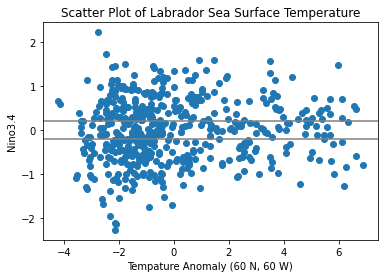

In [26]:
##Select out the point for the high composite value
pt_ts = ts_anoms.sel( lat = 60, lon = 360-60, method = 'nearest' );
plt.scatter( pt_ts['ts'], nino_ind );
plt.xlabel( 'Tempature Anomaly (60 N, 60 W)' );
plt.ylabel( 'Nino3.4' );

plt.axhline( 0.2, color = 'gray' );
plt.axhline( -0.2, color = 'gray' );
plt.title( 'Scatter Plot of Labrador Sea Surface Temperature')

In [27]:
##Create a climatology to find the precipitation anomalies
pr_climo = pr_ds.mean( dim = 'year' );
pr_anoms = pr_ds - pr_climo;
pr_anoms

<xarray.Dataset>
Dimensions:     (bnds: 2, lat: 90, lon: 144, year: 500)
Coordinates:
  * lat         (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon         (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * year        (year) int64 1 2 3 4 5 6 7 8 ... 493 494 495 496 497 498 499 500
Dimensions without coordinates: bnds
Data variables:
    lat_bnds    (year, lat, bnds) float64 dask.array<chunksize=(1, 90, 2), meta=np.ndarray>
    lon_bnds    (year, lon, bnds) float64 dask.array<chunksize=(1, 144, 2), meta=np.ndarray>
    pr          (year, lat, lon) float32 dask.array<chunksize=(1, 90, 144), meta=np.ndarray>
    average_DT  (year) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>

In [28]:
pos_pr = pr_anoms.sel( year = pos_nino.dropna( dim = 'year' )['year'] ).mean( dim = 'year' );
neg_pr = pr_anoms.sel( year = neg_nino.dropna( dim = 'year' )['year'] ).mean( dim = 'year' );
neutral_pr = pr_anoms.sel( year = neutral.dropna( dim = 'year' )['year'] ).mean( dim = 'year' );

comp_pr = [pos_pr, neg_pr, neutral_pr];
print( comp_pr );
                             

[<xarray.Dataset>
Dimensions:     (bnds: 2, lat: 90, lon: 144)
Coordinates:
  * lat         (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon         (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Dimensions without coordinates: bnds
Data variables:
    lat_bnds    (lat, bnds) float64 dask.array<chunksize=(90, 2), meta=np.ndarray>
    lon_bnds    (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
    pr          (lat, lon) float32 dask.array<chunksize=(90, 144), meta=np.ndarray>
    average_DT  timedelta64[ns] dask.array<chunksize=(), meta=np.ndarray>, <xarray.Dataset>
Dimensions:     (bnds: 2, lat: 90, lon: 144)
Coordinates:
  * lat         (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon         (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Dimensions without coordinates: bnds
Data variables:
    lat_bnds    (lat, bnds) float64 dask.array<chunksize=(90, 2), meta=np.ndarray>
    lon_bnds    (lon, 

Text(0.5, 0.98, 'NOAA GFDL Composite Precipitation Anomalies during Variations in Nino3.4')

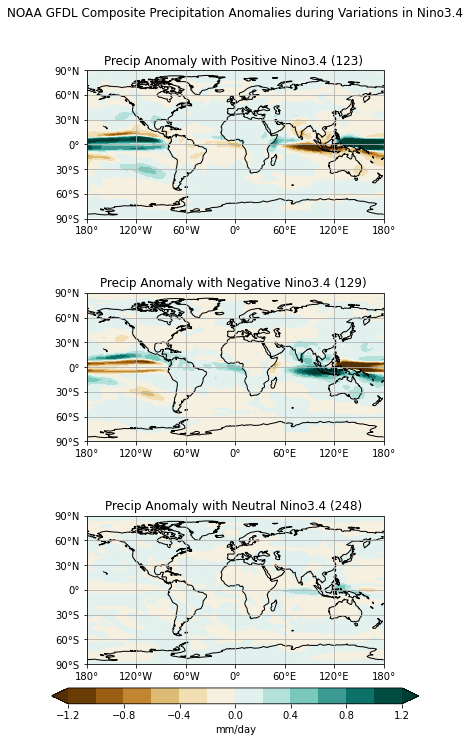

In [29]:
labels = ['Positive Nino3.4', 'Negative Nino3.4', 'Neutral Nino3.4'];
clevs = np.arange( -1.2, 1.4, 0.2 );

## Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots( nrows = 3, ncols = 1,
                       subplot_kw = {'projection': ccrs.PlateCarree() },
                       figsize = (8.5, 11) );
## axs is a 2 dimensional array of 'GeoAxes'.
##We will flatten this into a 1D array
axs = axs.flatten();

##Loop over each of the conditions and plot
for i, enso in enumerate( comp_pr ):
    ##Select the comp
    data = comp_pr[i]['pr'];
    ##Add the cyclic point
    data,lons = add_cyclic_point( data, coord = comp_pr[i]['lon'] );
    ##Create the contour plot
    cs = axs[i].contourf( lons, comp_pr[i]['lat'], data, clevs,
                        transform = ccrs.PlateCarree(),
                        cmap = 'BrBG', extend = 'both' );
    ##Longitude labels 
    axs[i].set_xticks( np.arange( -180, 181, 60 ), crs = ccrs.PlateCarree() );
    lon_formatter = cticker.LongitudeFormatter();
    axs[i].xaxis.set_major_formatter( lon_formatter );
    ##Latitude labels
    axs[i].set_yticks( np.arange( -90, 91, 30 ), crs = ccrs.PlateCarree() );
    lat_formatter = cticker.LatitudeFormatter();
    axs[i].yaxis.set_major_formatter( lat_formatter );
    ##Title each subplot with the name of the composite
    axs[i].set_title( 'Precip Anomaly with ' + labels[i] + ' (' + str(counts[i]) + ') ' );
    ##Draw the coastlines for each subplot
    axs[i].coastlines();
    axs[i].gridlines();
    
    
##Adjust the location of the subplots to make room for colorbar
fig.subplots_adjust( bottom = 0.15, top = 0.9, left = 0.05, right = 0.95,
                   wspace = 0.1, hspace = 0.5 );
##Add a colorbar axis
cbar_ax = fig.add_axes( [0.2, 0.1, 0.6, 0.02] );
cbar = fig.colorbar( cs, cax = cbar_ax, orientation = 'horizontal', label = 'mm/day' );

plt.suptitle( 'NOAA GFDL Composite Precipitation Anomalies during Variations in Nino3.4')

In [30]:
ptest = 0.05; 

a = pr_anoms.sel( year = pos_nino.dropna( dim = 'year' )['year'] );
b = pr_anoms.sel( year = neutral.dropna( dim = 'year' )['year'] );
c = pr_anoms.sel( year = neg_nino.dropna( dim = 'year' )['year'] );

pos_tstat,pos_pval = ttest_ind( a['pr'], b['pr'], equal_var = False );
neg_tstat,neg_pval = ttest_ind( c['pr'], b['pr'], equal_var = False );


In [31]:
pos_mask_diff = pos_pr['pr'].where( pos_pval < ptest );
neg_mask_diff = neg_pr['pr'].where( neg_pval < ptest );

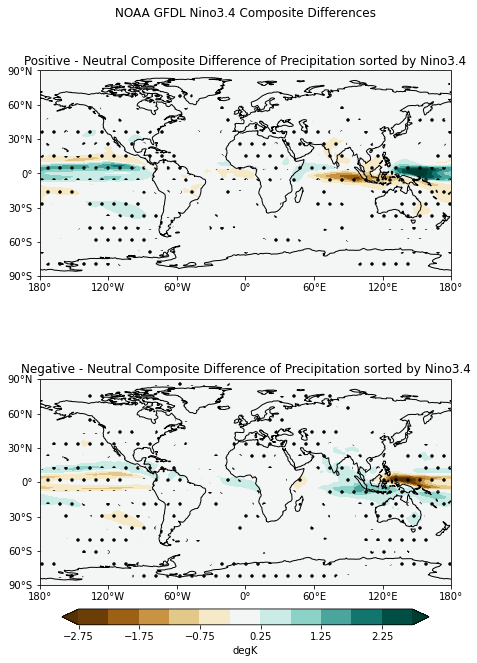

In [32]:
labels = ['Positive - Neutral', 'Negative - Neutral'];
clevs = np.arange( -2.75, 3.25, 0.5 );

fig, axs = plt.subplots( nrows = 2, ncols = 1,
                       subplot_kw = {'projection':ccrs.PlateCarree()},
                       figsize = (8.5,11) );
axs = axs.flatten();

#for i,enso in enumerate( diff_precip ):
data = pos_pr['pr'] - neutral_pr['pr'];

data,lons = add_cyclic_point( data, coord = pr_anoms['lon'] );
mask_data,lons = add_cyclic_point( pos_mask_diff, coord=pr_anoms['lon'] );

cs = axs[0].contourf( lons, pos_pr['lat'], data, clevs,
                        transform = ccrs.PlateCarree(),
                        cmap = 'BrBG', extend = 'both' );
axs[0].contourf( lons, pr_anoms['lat'], mask_data,
            [0,1], transform = ccrs.PlateCarree(), colors = 'None',
            hatches = ['.'], extend = 'both', alpha = 0 );
axs[0].set_title( labels[0] + ' Composite Difference of Precipitation sorted by Nino3.4' );
axs[0].coastlines();
##Longitude Labels
axs[0].set_xticks( np.arange( -180, 181, 60 ), crs = ccrs.PlateCarree() );
lon_formatter = cticker.LongitudeFormatter();
axs[0].xaxis.set_major_formatter( lon_formatter );
##Latitude labels
axs[0].set_yticks( np.arange( -90, 91, 30 ), crs = ccrs.PlateCarree() );
lat_formatter = cticker.LatitudeFormatter();
axs[0].yaxis.set_major_formatter( lat_formatter );


data = neg_pr['pr'] - neutral_pr['pr'];

data,lons = add_cyclic_point( data, coord = pr_anoms['lon'] );
mask_data,lons = add_cyclic_point( neg_mask_diff, coord=pr_anoms['lon'] );

cs = axs[1].contourf( lons, neg_pr['lat'], data, clevs,
                        transform = ccrs.PlateCarree(),
                        cmap = 'BrBG', extend = 'both' );
axs[1].contourf( lons, pr_anoms['lat'], mask_data,
            [0,1], transform = ccrs.PlateCarree(), colors = 'None',
            hatches = ['.'], extend = 'both', alpha = 0 );
axs[1].set_title( labels[1] + ' Composite Difference of Precipitation sorted by Nino3.4' );
axs[1].coastlines();
##Longitude Labels
axs[1].set_xticks( np.arange( -180, 181, 60 ), crs = ccrs.PlateCarree() );
lon_formatter = cticker.LongitudeFormatter();
axs[1].xaxis.set_major_formatter( lon_formatter );
##Latitude labels
axs[1].set_yticks( np.arange( -90, 91, 30 ), crs = ccrs.PlateCarree() );
lat_formatter = cticker.LatitudeFormatter();
axs[1].yaxis.set_major_formatter( lat_formatter );

    
fig.subplots_adjust( bottom = 0.25, top = 0.9, left = 0.05, right = 0.95,
                   wspace = 0.1, hspace = 0.5 );
cbar_ax = fig.add_axes( [0.2, 0.2, 0.6, 0.02] );
cbar = fig.colorbar( cs, cax = cbar_ax, orientation = 'horizontal', label = 'degK' );
plt.suptitle( 'NOAA GFDL Nino3.4 Composite Differences' );

## Correlation of the Calculated AMV Index with Surface Variables

In [33]:
r_map = xr.corr( nino_ind, sst_anoms['tos'], dim = 'year' );
r_map

<xarray.DataArray 'tos' (rlat: 200, rlon: 360)>
dask.array<truediv, shape=(200, 360), dtype=float64, chunksize=(200, 360), chunktype=numpy.ndarray>
Coordinates:
  * rlon     (rlon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * rlat     (rlat) float64 -81.5 -80.5 -79.5 -78.5 ... 86.5 87.5 88.5 89.5
    lat      (rlat, rlon) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>
    lon      (rlat, rlon) float32 dask.array<chunksize=(200, 360), meta=np.ndarray>

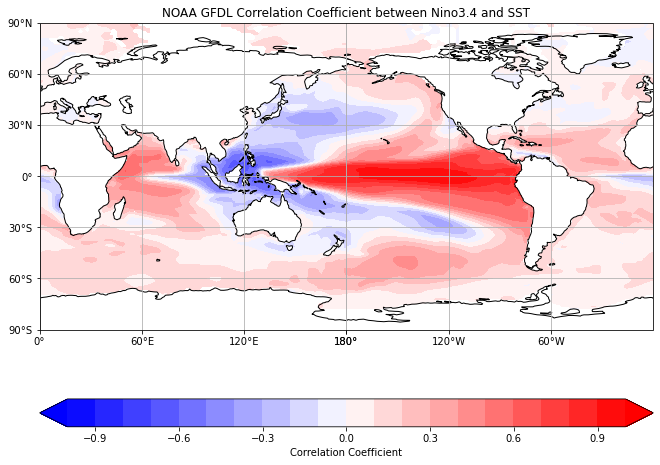

In [34]:
clevs = np.arange( -1, 1.1, 0.1 );
fig = plt.figure( figsize = (11,8.5) );

ax = plt.axes( projection=ccrs.PlateCarree( central_longitude = 180 ) );

data,lon = add_cyclic_point( r_map, coord = sst_anoms['rlon'] );
#mask_data,lon = add_cyclic_point( mask_sig, coord = ts_anoms['lon'] );

cs = ax.contourf( lon, sst_anoms['rlat'], data, clevs,
                transform = ccrs.PlateCarree(),
                cmap = 'bwr', extend = 'both' );
##Longitude Labels
ax.set_xticks( np.arange( -180, 181, 60 ), crs = ccrs.PlateCarree() );
lon_formatter = cticker.LongitudeFormatter();
ax.xaxis.set_major_formatter( lon_formatter );
##Latitude labels
ax.set_yticks( np.arange( -90, 91, 30 ), crs = ccrs.PlateCarree() );
lat_formatter = cticker.LatitudeFormatter();
ax.yaxis.set_major_formatter( lat_formatter );

ax.coastlines();
ax.gridlines();

cbar = plt.colorbar( cs, orientation = 'horizontal', label = 'Correlation Coefficient' );
plt.title( 'NOAA GFDL Correlation Coefficient between Nino3.4 and SST' );

In [35]:
r_map = xr.corr( nino_ind, ts_anoms['ts'], dim = 'year' );
r_map

<xarray.DataArray (lat: 90, lon: 144)>
dask.array<truediv, shape=(90, 144), dtype=float64, chunksize=(90, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8

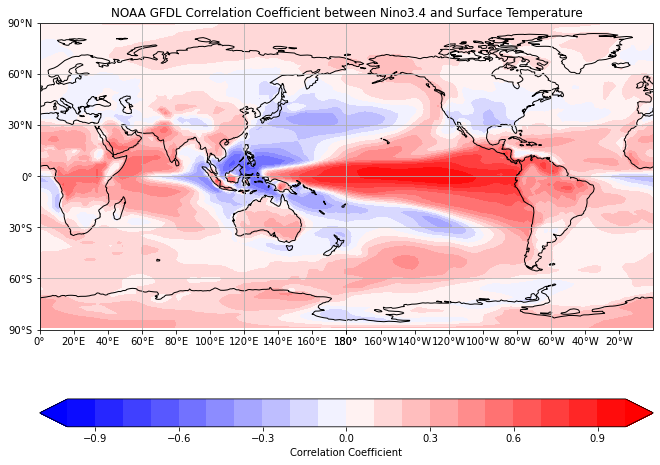

In [36]:
clevs = np.arange( -1, 1.1, 0.1 );
fig = plt.figure( figsize = (11,8.5) );

ax = plt.axes( projection=ccrs.PlateCarree( central_longitude = 180 ) );

data,lon = add_cyclic_point( r_map, coord = ts_anoms['lon'] );
#mask_data,lon = add_cyclic_point( mask_sig, coord = ts_anoms['lon'] );

cs = ax.contourf( lon, ts_anoms['lat'], data, clevs,
                transform = ccrs.PlateCarree(),
                cmap = 'bwr', extend = 'both' );
##Longitude Labels
ax.set_xticks( np.arange( -180, 181, 20 ), crs = ccrs.PlateCarree() );
lon_formatter = cticker.LongitudeFormatter();
ax.xaxis.set_major_formatter( lon_formatter );
##Latitude labels
ax.set_yticks( np.arange( -90, 91, 30 ), crs = ccrs.PlateCarree() );
lat_formatter = cticker.LatitudeFormatter();
ax.yaxis.set_major_formatter( lat_formatter );

ax.coastlines();
ax.gridlines();

cbar = plt.colorbar( cs, orientation = 'horizontal', label = 'Correlation Coefficient' );
plt.title( 'NOAA GFDL Correlation Coefficient between Nino3.4 and Surface Temperature' );

In [37]:
r_map = xr.corr( nino_ind, pr_anoms['pr'], dim = 'year' );
r_map

<xarray.DataArray (lat: 90, lon: 144)>
dask.array<truediv, shape=(90, 144), dtype=float64, chunksize=(90, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8

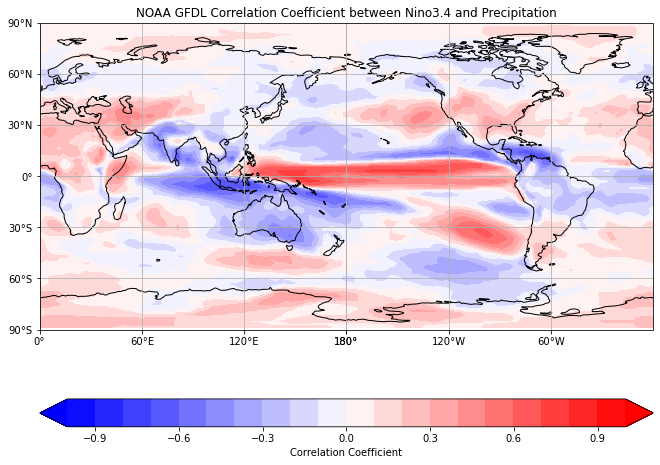

In [38]:
clevs = np.arange( -1, 1.1, 0.1 );
fig = plt.figure( figsize = (11,8.5) );

ax = plt.axes( projection=ccrs.PlateCarree( central_longitude = 180 ) );

data,lon = add_cyclic_point( r_map, coord = pr_anoms['lon'] );
#mask_data,lon = add_cyclic_point( mask_sig, coord = ts_anoms['lon'] );

cs = ax.contourf( lon, pr_anoms['lat'], data, clevs,
                transform = ccrs.PlateCarree(),
                cmap = 'bwr', extend = 'both' );
##Longitude Labels
ax.set_xticks( np.arange( -180, 181, 60 ), crs = ccrs.PlateCarree() );
lon_formatter = cticker.LongitudeFormatter();
ax.xaxis.set_major_formatter( lon_formatter );
##Latitude labels
ax.set_yticks( np.arange( -90, 91, 30 ), crs = ccrs.PlateCarree() );
lat_formatter = cticker.LatitudeFormatter();
ax.yaxis.set_major_formatter( lat_formatter );

ax.coastlines();
ax.gridlines();

cbar = plt.colorbar( cs, orientation = 'horizontal', label = 'Correlation Coefficient' );
plt.title( 'NOAA GFDL Correlation Coefficient between Nino3.4 and Precipitation' );

## Subset the North Atlantic Ocean as a region of interest

In [39]:
ts_na = ts_anoms.sel( lat = slice( 0, 60 ), lon = slice( 360-80, 360) );
ts_na

<xarray.Dataset>
Dimensions:     (bnds: 2, lat: 30, lon: 32, year: 500)
Coordinates:
  * lat         (lat) float64 1.0 3.0 5.0 7.0 9.0 ... 51.0 53.0 55.0 57.0 59.0
  * lon         (lon) float64 281.2 283.8 286.2 288.8 ... 353.8 356.2 358.8
  * year        (year) int64 1 2 3 4 5 6 7 8 ... 493 494 495 496 497 498 499 500
Dimensions without coordinates: bnds
Data variables:
    lat_bnds    (year, lat, bnds) float64 dask.array<chunksize=(1, 30, 2), meta=np.ndarray>
    lon_bnds    (year, lon, bnds) float64 dask.array<chunksize=(1, 32, 2), meta=np.ndarray>
    ts          (year, lat, lon) float32 dask.array<chunksize=(1, 30, 32), meta=np.ndarray>
    average_DT  (year) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>

In [40]:
nx = len( ts_na['lon'] );
ny = len( ts_na['lat'] );

r_array = np.zeros( (ny,nx) );
p_array = np.zeros( (ny,nx) );
#p_array = np.copy( r_array );

for i in range( nx ):
    print( i );
    for j in range( ny ):
        
        r,p = pearsonr( nino_ind, ts_na['ts'][:,j,i] );
        
        r_array[j,i] = r;
        p_array[j,i] = p;

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [41]:
ts_na['lon']

<xarray.DataArray 'lon' (lon: 32)>
array([281.25, 283.75, 286.25, 288.75, 291.25, 293.75, 296.25, 298.75, 301.25,
       303.75, 306.25, 308.75, 311.25, 313.75, 316.25, 318.75, 321.25, 323.75,
       326.25, 328.75, 331.25, 333.75, 336.25, 338.75, 341.25, 343.75, 346.25,
       348.75, 351.25, 353.75, 356.25, 358.75])
Coordinates:
  * lon      (lon) float64 281.2 283.8 286.2 288.8 ... 351.2 353.8 356.2 358.8
Attributes:
    long_name:      longitude
    units:          degrees_east
    bounds:         lon_bnds
    standard_name:  longitude
    axis:           X

In [42]:
mask_sig = np.where( p_array < 0.05, 1, np.nan );
mask_sig

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1., nan, nan, nan, nan,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1., nan, nan],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan, nan,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.],
       [nan,  1.,  1.,  1.,  1.,  1., nan,  1., nan,  1.,  1.,  1.,  1.,
  

Text(0.5, 1.0, 'NOAA GFDL Correlation Coefficients for Surface Temperature against Nino3.4')

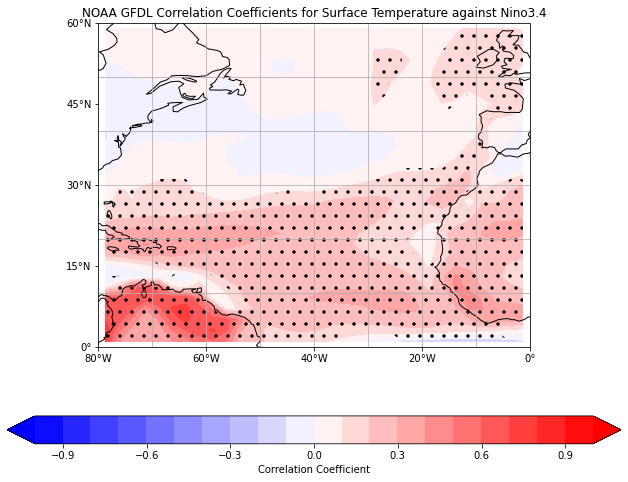

In [43]:
clevs = np.arange( -1, 1.1, 0.1 );
fig = plt.figure( figsize = (11,8.5) );

ax = plt.axes( projection=ccrs.PlateCarree() );

cs = ax.contourf( ts_na['lon'], ts_na['lat'], r_array, clevs,
                transform = ccrs.PlateCarree(),
                cmap = 'bwr', extend = 'both' );
ax.contourf( ts_na['lon'], ts_na['lat'], mask_sig, [0,1],
           transform = ccrs.PlateCarree(), colors = 'None',
           hatches = ['.'], extend = 'both', alpha = 0 );

##Longitude labels 
ax.set_xticks( np.arange( -80, 1, 20 ), crs = ccrs.PlateCarree() );
lon_formatter = cticker.LongitudeFormatter();
ax.xaxis.set_major_formatter( lon_formatter );
##Latitude labels
ax.set_yticks( np.arange( 0, 61, 15 ), crs = ccrs.PlateCarree() );
lat_formatter = cticker.LatitudeFormatter();
ax.yaxis.set_major_formatter( lat_formatter );

ax.coastlines()
ax.gridlines();

cbar = plt.colorbar( cs, orientation = 'horizontal', label = 'Correlation Coefficient' );
plt.title( 'NOAA GFDL Correlation Coefficients for Surface Temperature against Nino3.4')

## Linear Regression Analysis

In [ ]:

nx = len( ts_na['lon'] );
ny = len( ts_na['lat'] );

#Create empty arrays to store the linregress output
m_array = np.zeros( ( ny, nx ) );
r_array = np.zeros( ( ny, nx ) );
p_array = np.zeros( ( ny, nx ) );


for i in range( nx ):
    print( i );
    for j in range( ny ):
        
        x = nino_ind;
        y = ts_na['ts'][:,j,i];
        m_array[j,i],b,r_array[j,i],p_array[j,i],e = lr( x, y)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


In [ ]:
mask_sig = np.where( p_array < 0.05, 1, np.nan );
mask_sig

In [ ]:
clevs = np.arange( -0.3, 0.4, 0.1 );
fig = plt.figure( figsize = (11,8.5) );
ax = plt.axes( projection = ccrs.PlateCarree() );

cs = ax.contourf( ts_na['lon'], ts_na['lat'], m_array, clevs,
                transform = ccrs.PlateCarree(),
                cmap = 'RdBu_r', extend = 'both' );
#Could give contour levels (especially if the mask has levels), with the symbols assigned by hatches corresponding to each contour level
ax.contourf( ts_na['lon'], ts_na['lat'], mask_sig, 
           transform = ccrs.PlateCarree(), colors = 'None',
            hatches = ['.'], extend = 'both', alpha = 0 )

##Longitude labels 
ax.set_xticks( np.arange( -80, 1, 20 ), crs = ccrs.PlateCarree() );
lon_formatter = cticker.LongitudeFormatter();
ax.xaxis.set_major_formatter( lon_formatter );
##Latitude labels
ax.set_yticks( np.arange( 0, 61, 15 ), crs = ccrs.PlateCarree() );
lat_formatter = cticker.LatitudeFormatter();
ax.yaxis.set_major_formatter( lat_formatter );
ax.coastlines();
ax.gridlines();

cbar = plt.colorbar( cs, orientation = 'horizontal', label = 'Regression Coefficient' );
plt.title( 'NOAA GFDL Surface Temperature Regression Coefficient w/ NINO34 hatched with Significance > 95%' );